In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import optuna
from rdkit import RDLogger
import warnings

# Suppress warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")


## Loading ClinTox dataset

**ClinTox:** Qualitative data of drugs approved by the FDA and those that have failed clinical trials for toxicity reasons.

In [2]:
clintox_df= pd.read_csv('clintox.csv')
print(clintox_df.shape)
clintox_df.head()

(1484, 3)


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [3]:
clintox_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   smiles        1484 non-null   object
 1   FDA_APPROVED  1484 non-null   int64 
 2   CT_TOX        1484 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 34.9+ KB


In [4]:
count_matrix = pd.crosstab(clintox_df['FDA_APPROVED'], clintox_df['CT_TOX'])
count_matrix

CT_TOX,0,1
FDA_APPROVED,,
0,0,94
1,1372,18


 - You have 1,484 molecules total.

 - Most (1372) are approved & non-toxic.

 - 94 are not approved & toxic.

 - 18 are approved & toxic (rare).

 - 0 are not approved & non-toxic — that’s interesting.

🧩 What This Means

Let’s interpret biologically and for ML purposes.

1️⃣ There’s a strong correlation between the two tasks

Toxicity almost perfectly separates approved vs. not approved.

Almost all approved drugs are non-toxic.

All unapproved drugs are toxic.

This means our task is not independent and toxicity basically determines approval.

In [5]:
def smiles_to_fp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((n_bits,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [6]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
import numpy as np

def smiles_to_fp(smiles, radius=2, n_bits=2048):
    """
    Convert a SMILES string into a combined molecular feature vector
    (Morgan fingerprint + selected physicochemical descriptors).
    
    Args:
        smiles (str): Molecule SMILES string.
        radius (int): Morgan fingerprint radius.
        n_bits (int): Number of bits in fingerprint.
    
    Returns:
        np.ndarray: Feature vector of length (n_bits + num_descriptors).
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # return zeros for invalid SMILES
        return np.zeros((n_bits + 7,), dtype=float)
    
    # --- Morgan fingerprint ---
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    # --- Physicochemical descriptors ---
    desc_list = [
        Descriptors.MolWt(mol),            # molecular weight
        Descriptors.MolLogP(mol),          # logP (hydrophobicity)
        Descriptors.NumHAcceptors(mol),    # hydrogen bond acceptors
        Descriptors.NumHDonors(mol),       # hydrogen bond donors
        Descriptors.TPSA(mol),             # topological polar surface area
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol)
    ]
    desc = np.array(desc_list, dtype=float)
    
    # --- Combine fingerprint + descriptors ---
    features = np.concatenate([arr, desc])
    
    return features


In [7]:
X = np.array([smiles_to_fp(s) for s in clintox_df['smiles']])
y = clintox_df[['FDA_APPROVED', 'CT_TOX']].values

In [8]:
X

array([[  0.  ,   1.  ,   0.  , ..., 112.19,  13.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   1.  ],
       [  0.  ,   1.  ,   0.  , ..., 161.18,   5.  ,   0.  ],
       ...,
       [  0.  ,   0.  ,   0.  , ...,  17.07,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,  89.41,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])

In [9]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13, stratify=y
)

In [11]:
def multilabel_macro_f1(y_true, y_pred):
    """
    Compute macro-average F1 across all labels for multi-label classification.
    This treats each label equally.
    """
    n_labels = y_true.shape[1]
    f1s = []
    for i in range(n_labels):
        f1 = f1_score(y_true[:, i], y_pred[:, i], average='macro')
        f1s.append(f1)
    return np.mean(f1s)
    
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    
    multi_rf = MultiOutputClassifier(rf)
    
    # 5-Fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        multi_rf.fit(X_train, y_train)
        y_pred = multi_rf.predict(X_test)
        score = multilabel_macro_f1(y_test, y_pred)
        scores.append(score)
    
    return np.mean(scores)


In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15) 

print("Best F1 score:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-10-25 01:55:21,992] A new study created in memory with name: no-name-0dce4eba-a410-413c-a402-ece68b5f385e
[I 2025-10-25 01:55:39,154] Trial 0 finished with value: 0.6267653452999435 and parameters: {'n_estimators': 347, 'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6267653452999435.
[I 2025-10-25 01:55:58,506] Trial 1 finished with value: 0.6365076744197813 and parameters: {'n_estimators': 389, 'max_depth': 35, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.6365076744197813.
[I 2025-10-25 01:56:18,895] Trial 2 finished with value: 0.644557180230563 and parameters: {'n_estimators': 412, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.644557180230563.
[I 2025-10-25 01:56:35,303] Trial 3 finished with value: 0.680809821604311 and parameters: {'n_estimators': 320, 'max_depth': 25, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 3 with value

Best F1 score: 0.680809821604311
Best hyperparameters: {'n_estimators': 320, 'max_depth': 25, 'min_samples_split': 12, 'min_samples_leaf': 7}


In [84]:
best_params = study.best_params

final_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

final_model = MultiOutputClassifier(final_rf)
final_model.fit(X_train, y_train)

print("Final multi-label Random Forest trained!")

Final multi-label Random Forest trained!


In [94]:
# Predict
y_prob = final_model.predict_proba(X_test)
y_pred = final_model.predict(X_test)

In [96]:
from sklearn.metrics import classification_report
labels = ['FDA_APPROVED', 'CT_TOX']  
for i, label in enumerate(labels):
    print(f"=== {label} ===")
    print(classification_report(y_test[:, i], y_pred[:, i]))


=== FDA_APPROVED ===
              precision    recall  f1-score   support

           0       0.30      0.53      0.38        19
           1       0.97      0.92      0.94       278

    accuracy                           0.89       297
   macro avg       0.63      0.72      0.66       297
weighted avg       0.92      0.89      0.91       297

=== CT_TOX ===
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       274
           1       0.28      0.48      0.35        23

    accuracy                           0.86       297
   macro avg       0.61      0.69      0.64       297
weighted avg       0.90      0.86      0.88       297



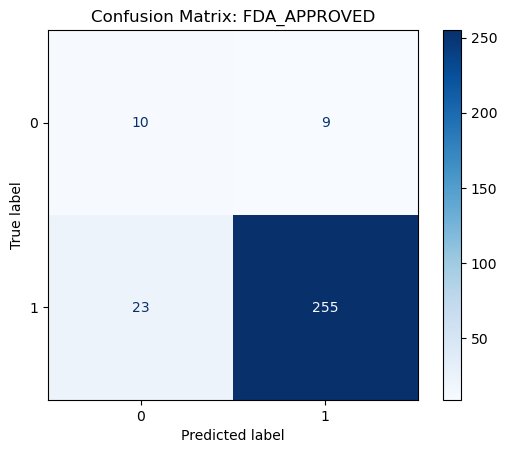

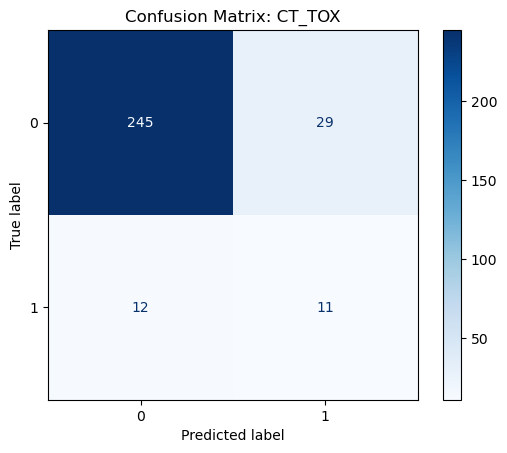

In [97]:
for i, label in enumerate(labels):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {label}')
    plt.show()

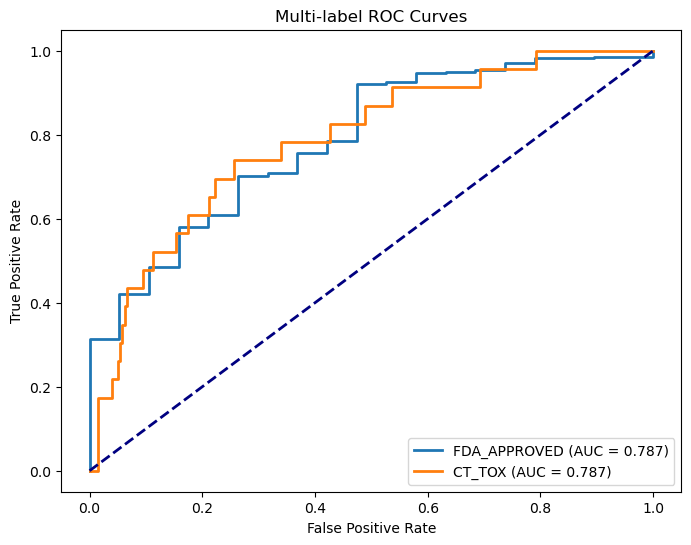

In [98]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for i, label in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_prob[i][:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.3f})')

plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-label ROC Curves')
plt.legend(loc="lower right")
plt.show()


In [28]:
final_model.fit(X, y)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=25,
                                                       min_samples_leaf=7,
                                                       min_samples_split=12,
                                                       n_estimators=320,
                                                       n_jobs=-1,
                                                       random_state=42))

In [36]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd

def predict_multilabel(smiles_list, model, radius=2, n_bits=2048):
    """
    Predict multi-label outputs (FDA_APPROVED, CT_TOX) for a list of SMILES.
    
    Supports both scikit-learn MultiOutputClassifier and Keras/TensorFlow models.
    
    Args:
        smiles_list (list of str): List of SMILES strings.
        model: Trained model (sklearn or Keras NN).
        radius (int): Morgan fingerprint radius.
        n_bits (int): Number of bits in fingerprint.
    
    Returns:
        pd.DataFrame: Columns -> SMILES, FDA_APPROVED, FDA_Prob, CT_TOX, CT_Prob
    """
    def smiles_to_fp(smiles, radius=2, n_bits=2048):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # return zeros for invalid SMILES
            return np.zeros((n_bits + 7,), dtype=float)
        
        # --- Morgan fingerprint ---
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=int)
        DataStructs.ConvertToNumpyArray(fp, arr)
        
        # --- Physicochemical descriptors ---
        desc_list = [
            Descriptors.MolWt(mol),            # molecular weight
            Descriptors.MolLogP(mol),          # logP (hydrophobicity)
            Descriptors.NumHAcceptors(mol),    # hydrogen bond acceptors
            Descriptors.NumHDonors(mol),       # hydrogen bond donors
            Descriptors.TPSA(mol),             # topological polar surface area
            Descriptors.NumRotatableBonds(mol),
            Descriptors.RingCount(mol)
        ]
        desc = np.array(desc_list, dtype=float)
        # --- Combine fingerprint + descriptors ---
        features = np.concatenate([arr, desc])
        
        return features
    
    # Convert SMILES to feature matrix
    X_new = np.array([smiles_to_fp(s) for s in smiles_list])
    
    # Detect if model is a Keras model
    is_keras = hasattr(model, "predict") and not hasattr(model, "predict_proba")
    
    if is_keras:
        # NN model: predict() gives probabilities
        probs = model.predict(X_new)
        # Threshold at 0.5 for class labels
        preds = (probs >= 0.5).astype(int)
        fda_probs = probs[:, 0]
        tox_probs = probs[:, 1]
    else:
        # scikit-learn model
        preds = model.predict(X_new)
        prob_list = model.predict_proba(X_new)
        # prob_list is a list of arrays, one per output
        fda_probs = prob_list[0][:, 1] if prob_list[0].ndim == 2 else prob_list[0]
        tox_probs = prob_list[1][:, 1] if prob_list[1].ndim == 2 else prob_list[1]
    
    results = pd.DataFrame({
        "SMILES": smiles_list,
        "FDA_APPROVED": preds[:, 0],
        "FDA_Prob": fda_probs,
        "CT_TOX": preds[:, 1],
        "CT_Prob": tox_probs
    })
    
    return results


In [37]:
new_smiles = [
    "CC1(C(=O)NC2=CC=CC=C12)C(=O)NC3=CC=CC=C3",  # Thalidomide
    "CC1=CC(=O)OC2=C1C=CC(=C2)S(=O)(=O)C3=CC=CC=C3",  # Rofecoxib (Vioxx)
    "CN1CCN(CC1)CCOC2=CC=CC=C2C3=CC=CC=C3C(=O)O",  # Cisapride
    "CC1=CC(=O)C(=CC1O)CC2=CC=C(C=C2)OCC3=CC=CC=C3O",  # Troglitazone
    "CC(C)C1=CC=C(C=C1)C(C(C2=CC=C(C=C2)F)O)OCC(=O)NC(CC3=CC=CC=C3)C(=O)O",  # Cerivastatin
    "C1=CC(=O)N(C(=O)N1)C2=CC=CC=C2",  # Pemoline
    "CC1=CN(C2=CC(=O)C3=C(O2)C=CC=C3F)C(=O)C4=CC=CC=N4",  # Trovafloxacin
    "CCOC1=CC=C(C=C1)NC(=O)C",  # Phenacetin
    "CC1=CC(=O)OC2=C1C=CC=C2C(=O)O",  # Benoxaprofen
    "CC(C)(C1=CC=C(C=C1)COCCN2CCC(CC2)C3=CC=CC=C3)O"  # Terfenadine
]
df_preds = predict_multilabel(new_smiles, final_model)
df_preds

,SMILES,FDA_APPROVED,FDA_Prob,CT_TOX,CT_Prob
0,CC1(C(=O)NC2=CC=CC=C12)C(=O)NC3=CC=CC=C3,1,0.641193,0,0.422913
1,CC1=CC(=O)OC2=C1C=CC(=C2)S(=O)(=O)C3=CC=CC=C3,1,0.742697,0,0.259351
2,CN1CCN(CC1)CCOC2=CC=CC=C2C3=CC=CC=C3C(=O)O,0,0.485492,1,0.531650
3,CC1=CC(=O)C(=CC1O)CC2=CC=C(C=C2)OCC3=CC=CC=C3O,1,0.658178,0,0.326817
4,CC(C)C1=CC=C(C=C1)C(C(C2=CC=C(C=C2)F)O)OCC(=O)...,1,0.546555,0,0.491033
5,C1=CC(=O)N(C(=O)N1)C2=CC=CC=C2,1,0.729164,0,0.337209
6,CC1=CN(C2=CC(=O)C3=C(O2)C=CC=C3F)C(=O)C4=CC=CC=N4,1,0.792416,0,0.198413
7,CCOC1=CC=C(C=C1)NC(=O)C,1,0.694089,0,0.318704
8,CC1=CC(=O)OC2=C1C=CC=C2C(=O)O,1,0.703117,0,0.296183
9,CC(C)(C1=CC=C(C=C1)COCCN2CCC(CC2)C3=CC=CC=C3)O,1,0.604872,0,0.407867


## NN Approach

In [128]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

# --- Custom callback: print progress every N epochs ---
class EveryNthEpoch(tf.keras.callbacks.Callback):
    def __init__(self, n=5):
        super().__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            print(f"Epoch {epoch+1:03d}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

# --- Normalize features ---
print("🔹 Normalizing features with StandardScaler...")
scaler = StandardScaler()

# Fit scaler on training set, transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Define model architecture ---
n_features = X_train_scaled.shape[1]
n_labels = y_train.shape[1]

NN_model = Sequential([
    Dense(256, input_dim=n_features, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dense(n_labels, activation='sigmoid')  # multilabel output
])

# --- Compile model ---
NN_model.compile(
    loss='binary_crossentropy',       # multilabel classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# --- Define callbacks ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
nth_callback = EveryNthEpoch(n=5)

# --- Train model ---
print("🚀 Training neural network...")
history = NN_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, nth_callback],
    verbose=0
)

# --- Predict on test data ---
print("🧠 Generating predictions...")
y_pred_prob = NN_model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

🔹 Normalizing features with StandardScaler...
🚀 Training neural network...
Epoch 005: loss=0.2422, val_loss=0.3869
Epoch 010: loss=0.1416, val_loss=0.3666
🧠 Generating predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


In [129]:
from sklearn.metrics import classification_report

label_names = ["FDA_APPROVED", "CT_TOX"]

for i, label in enumerate(label_names):
    print(f"\n=== {label} ===")
    print(classification_report(y_test[:, i], y_pred[:, i]))



=== FDA_APPROVED ===
              precision    recall  f1-score   support

           0       0.25      0.21      0.23        19
           1       0.95      0.96      0.95       278

    accuracy                           0.91       297
   macro avg       0.60      0.58      0.59       297
weighted avg       0.90      0.91      0.91       297


=== CT_TOX ===
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       274
           1       0.23      0.30      0.26        23

    accuracy                           0.87       297
   macro avg       0.59      0.61      0.60       297
weighted avg       0.89      0.87      0.88       297



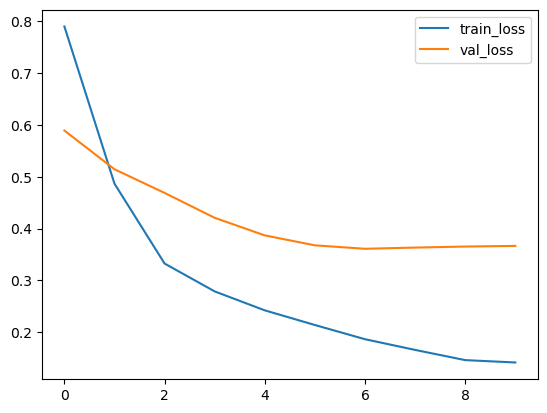

In [130]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()

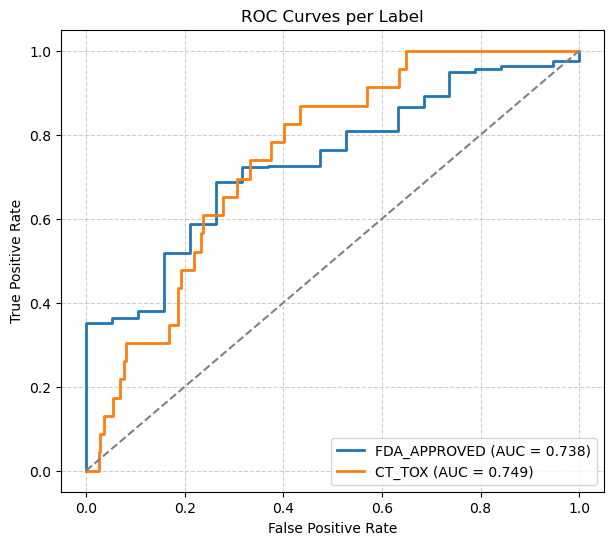

FDA_APPROVED: ROC-AUC = 0.7376
CT_TOX: ROC-AUC = 0.7488


In [132]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# --- Compute ROC-AUC per label ---
n_labels = y_test.shape[1]
label_names = ['FDA_APPROVED', 'CT_TOX']  # adjust to your actual label names

plt.figure(figsize=(7, 6))

for i in range(n_labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'{label_names[i]} (AUC = {roc_auc:.3f})')

# Plot chance line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.title('ROC Curves per Label')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Print numeric AUC scores ---
for i, label in enumerate(label_names):
    auc_value = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
    print(f"{label}: ROC-AUC = {auc_value:.4f}")


In [131]:
new_smiles = [
    "CC1(C(=O)NC2=CC=CC=C12)C(=O)NC3=CC=CC=C3",  # Thalidomide
    "CC1=CC(=O)OC2=C1C=CC(=C2)S(=O)(=O)C3=CC=CC=C3",  # Rofecoxib (Vioxx)
    "CN1CCN(CC1)CCOC2=CC=CC=C2C3=CC=CC=C3C(=O)O",  # Cisapride
    "CC1=CC(=O)C(=CC1O)CC2=CC=C(C=C2)OCC3=CC=CC=C3O",  # Troglitazone
    "CC(C)C1=CC=C(C=C1)C(C(C2=CC=C(C=C2)F)O)OCC(=O)NC(CC3=CC=CC=C3)C(=O)O",  # Cerivastatin
    "C1=CC(=O)N(C(=O)N1)C2=CC=CC=C2",  # Pemoline
    "CC1=CN(C2=CC(=O)C3=C(O2)C=CC=C3F)C(=O)C4=CC=CC=N4",  # Trovafloxacin
    "CCOC1=CC=C(C=C1)NC(=O)C",  # Phenacetin
    "CC1=CC(=O)OC2=C1C=CC=C2C(=O)O",  # Benoxaprofen
    "CC(C)(C1=CC=C(C=C1)COCCN2CCC(CC2)C3=CC=CC=C3)O"  # Terfenadine
]
df_preds = predict_multilabel(new_smiles, NN_model)
df_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


,SMILES,FDA_APPROVED,FDA_Prob,CT_TOX,CT_Prob
0,CC1(C(=O)NC2=CC=CC=C12)C(=O)NC3=CC=CC=C3,1,0.999999,0,0.125011
1,CC1=CC(=O)OC2=C1C=CC(=C2)S(=O)(=O)C3=CC=CC=C3,1,1.000000,0,0.074392
2,CN1CCN(CC1)CCOC2=CC=CC=C2C3=CC=CC=C3C(=O)O,1,1.000000,0,0.179198
3,CC1=CC(=O)C(=CC1O)CC2=CC=C(C=C2)OCC3=CC=CC=C3O,1,1.000000,0,0.071291
4,CC(C)C1=CC=C(C=C1)C(C(C2=CC=C(C=C2)F)O)OCC(=O)...,1,1.000000,0,0.025487
5,C1=CC(=O)N(C(=O)N1)C2=CC=CC=C2,1,0.999975,0,0.144132
6,CC1=CN(C2=CC(=O)C3=C(O2)C=CC=C3F)C(=O)C4=CC=CC=N4,1,0.964392,0,0.020603
7,CCOC1=CC=C(C=C1)NC(=O)C,1,0.999914,0,0.197119
8,CC1=CC(=O)OC2=C1C=CC=C2C(=O)O,1,0.999994,0,0.103211
9,CC(C)(C1=CC=C(C=C1)COCCN2CCC(CC2)C3=CC=CC=C3)O,1,1.000000,0,0.246421
